<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# Проект «Анализ вакансий из HeadHunter»
   

In [2]:
# импорт необходимых библиотек, требующихся для выполнения всех заданий
# выключение предупреждений (предупреждение о том, что pandas поддерживает только SQLAlchemy connectable (engine/connection) или URL-адрес строки базы данных или подключение sqlite3 DBAPI2)

import pandas as pd
import psycopg2
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
warnings.filterwarnings('ignore')

In [4]:
connection = psycopg2.connect(
    dbname=DBNAME,
    user=USER,
    host=HOST,
    password=PASSWORD,
    port=PORT
)

## 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в базе (вакансии находятся в таблице `vacancies`).

In [5]:
# текст запроса
query_3_1 = f'''SELECT COUNT(*) vacancies
                FROM public.vacancies;
             '''

In [6]:
# результат запроса
df = pd.read_sql_query(query_3_1, connection)
df

,vacancies
0,49197


2. Напишите запрос, который посчитает количество работодателей (таблица `employers`).

In [7]:
# текст запроса
query_3_2 = f'''SELECT COUNT(*) employers_count
                FROM public.employers;
             '''

In [8]:
# результат запроса
df = pd.read_sql_query(query_3_2, connection)
df

,employers_count
0,23501


3. Посчитайте с помощью запроса количество регионов (таблица `areas`).

In [9]:
# текст запроса
query_3_3 = f'''SELECT COUNT(*) regions_count
                FROM public.areas;
             '''

In [10]:
# результат запроса
df = pd.read_sql_query(query_3_3, connection)
df

,regions_count
0,1362


4. Посчитайте с помощью запроса количество сфер деятельности в базе (таблица `industries`).

In [11]:
# текст запроса
query_3_4 = f'''SELECT COUNT(*) industries_count
                FROM public.industries;
             '''

In [12]:
# результат запроса
df = pd.read_sql_query(query_3_4, connection)
df

,industries_count
0,294


***

5. Опредилим топ-100 работодателей по количеству вакансий, а также среднюю зарплату по всем вакансиям работодателя, минимальную и максимальную зарплату

In [13]:
query_3_5 = f'''SELECT
                    e.name,
                    COUNT(v.id) AS vacancies,  -- подсчитываем количество вакансий для каждой компании
                    ROUND(AVG(  -- вычисляем среднюю зарплату
                        CASE
                            WHEN v.salary_from IS NOT NULL OR v.salary_to IS NOT NULL  -- если хотя бы одно поле зарплаты не пустое
                            THEN (COALESCE(v.salary_from, v.salary_to) + COALESCE(v.salary_to, v.salary_from)) / 2.0  -- если оба поля зарплаты заполнены, считаем среднее значение
                        END
                    ))::int AS avg_salary,  -- округляем среднее значение зарплаты до целого числа
                    ROUND(MIN(  -- находим минимальную зарплату
                        CASE
                            WHEN v.salary_from IS NOT NULL OR v.salary_to IS NOT NULL
                            THEN (COALESCE(v.salary_from, v.salary_to) + COALESCE(v.salary_to, v.salary_from)) / 2.0
                        END
                    ))::int AS min_salary,  -- округляем минимальную зарплату до целого числа
                    ROUND(MAX(  -- находим максимальную зарплату
                        CASE
                            WHEN v.salary_from IS NOT NULL OR v.salary_to IS NOT NULL
                            THEN (COALESCE(v.salary_from, v.salary_to) + COALESCE(v.salary_to, v.salary_from)) / 2.0
                        END
                    ))::int AS max_salary  -- округляем максимальную зарплату до целого числа
                FROM vacancies v
                LEFT JOIN employers e ON v.employer_id = e.id  -- присоединяем информацию о работодателях по id
                GROUP BY e.id, e.name  -- группируем по id и названию работодателя
                ORDER BY vacancies DESC  -- сортируем по убыванию
                LIMIT 100;  -- выводим топ-100
             '''

In [14]:
# выводы по предварительному анализу данных
df = pd.read_sql_query(query_3_5, connection)
df

,name,vacancies,avg_salary,min_salary,max_salary
0,Яндекс,1933,25884.0,13000.0,120000.0
1,Ростелеком,491,46980.0,15000.0,255000.0
2,Тинькофф,444,50143.0,40000.0,61000.0
3,СБЕР,428,153847.0,38000.0,320000.0
4,Газпром нефть,331,56000.0,42000.0,70000.0
...,...,...,...,...,...
95,РТ МИС,45,45000.0,35000.0,50000.0
96,Эр-1,44,NaN,NaN,NaN
97,LeverX International,43,NaN,NaN,NaN
98,"Ресурс, ГАП",43,68607.0,41250.0,82500.0


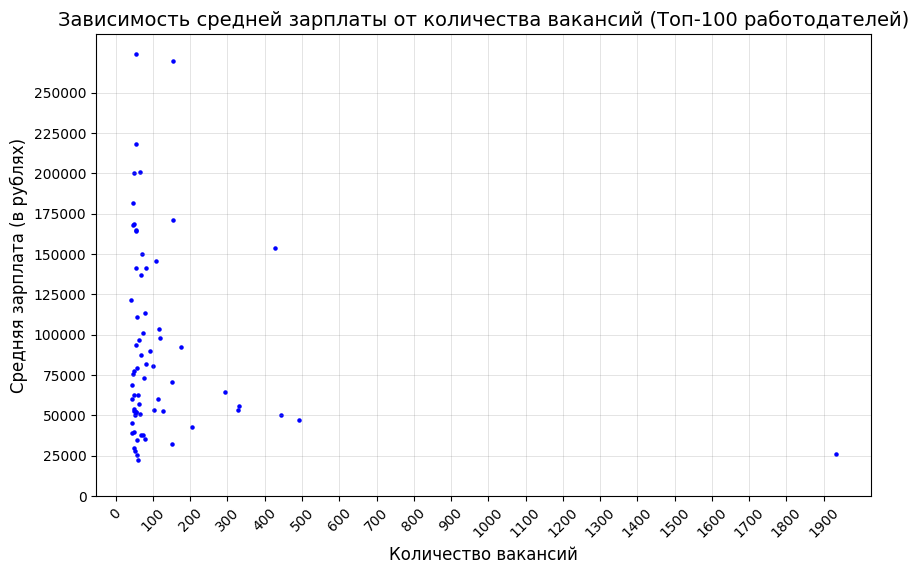

In [15]:
df = pd.read_sql_query(query_3_5, connection)

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(df['vacancies'], df['avg_salary'], color='blue', s=5)
plt.title('Зависимость средней зарплаты от количества вакансий (Топ-100 работодателей)', fontsize=14)
plt.xlabel('Количество вакансий', fontsize=12)
plt.ylabel('Средняя зарплата (в рублях)', fontsize=12)

# Задаем шаг на осях X и Y
plt.xticks(range(0, int(df['vacancies'].max()), 100), rotation=45)
plt.yticks(range(0, int(df['avg_salary'].max()), 25000))

plt.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
plt.show()

6. Вычислим количество работодателей, у которых нет активных вакансий

In [16]:
# текст запроса
query_3_6 = f'''SELECT
                    (SELECT COUNT(id) FROM employers) employers_all, -- все работодатели
                    (SELECT COUNT(DISTINCT employer_id) FROM vacancies) employers_with_vacancies, -- все работодатели с вакансиями
                    (SELECT COUNT(id) FROM employers) - (SELECT COUNT(DISTINCT employer_id) FROM vacancies) employers_without_vacancies -- разница, работодатели без вакансий
             '''

In [17]:
# выводы по предварительному анализу данных
df = pd.read_sql_query(query_3_6, connection)
df

,employers_all,employers_with_vacancies,employers_without_vacancies
0,23501,14906,8595


7. Вычислим количество регионов, в которых нет активных вакансий

In [18]:
query_3_7 = f'''SELECT COUNT(*) regions_without_vacancies
                FROM areas a
                LEFT JOIN vacancies v ON a.id = v.area_id  -- соединяем таблицу регионов с таблицей вакансий
                WHERE v.area_id IS NULL;  -- выбираем только те регионы, в которых нет вакансий
             '''

In [19]:
# выводы по предварительному анализу данных
df = pd.read_sql_query(query_3_7, connection)
df

,regions_without_vacancies
0,593


## **Выводы по предварительному анализу данных**

В ходе предварительного анализа данных были получены следующие результаты:

1. В базе данных 49 197 вакансий. Это свидетельствует о большом объеме данных и широких возможностях для соискателей на платформе.
2. В базе зарегистрировано 23 501 работодателей. Большое количество работодателей указывает на высокий интерес со стороны компаний к данной платформе для поиска работников. Однако 8 595 работодателей (36,57% от общего числа работодателей) зарегистрированных в базе не имеют активных вакансий, поэтому общее количество работодателей с вакансиями составляет 14 906 (63,43% от общего числа работодателей). Таким образом, среднее количество вакансий у работадателя - 3.
3. В базе данных представлено 1 362 региона. Это свидетельствует о том, что рынок труда  является более доступным для соискателей по всей стране, а также за ее пределами. Однако в 593 (43,54% от общего числа регионов) регионах не представлено активных вакансий, поэтому общее количество регионов с вакансиями - 769 (56,46% от общего числа регионов в базе данных).
4. В базе данных представлено 294 сферы деятельности. Это значительное разнообразие, которое позволяет специалистам в разных областях найти подходящие предложения работы, а работодателям — находить нужных кандидатов.

5. Наибольшее число вакансий представлено у Яндекса (1933), что значительно превышает показатели других компаний. За ним следуют Ростелеком (491), Тинькофф (444) и СБЕР (428). Это указывает на высокую активность крупных компаний в найме сотрудников.

- Средние зарплаты:
 - Максимальная средняя зарплата наблюдается у Andersen (269 475) и Social Discovery Ventures (273 977), что может быть связано с высококвалифицированными позициями или спецификой отрасли (например, IT, финансы).
 - Минимальная средняя зарплата у Beeline (21 968) и Почты России (35 278), что отражает либо низкооплачиваемые позиции, либо региональные различия. У Яндекса низкая средняя заработная плата (25 884) может быть связана как и с большим количеством низкооплачиваемых вакансий или вакансий начального уровня (junior-специалистов или стажеров), так и с самым большим количеством вакансий в базе данных (1933).

- Разброс зарплат:
 - Наибольший разрыв между минимальной и максимальной зарплатой у СБЕР (от 38 000 до 320 000) и Social Discovery Ventures (от 175 346 до 350 691), что характерно для компаний с широким спектром должностей (от рядовых сотрудников до топ-менеджеров).
 - У Норникеля и 2ГИС зарплаты фиксированы (отсутствует разброс), что может быть связано с узкой специализацией или стандартизированными условиями труда.

- Пропущенные данные:
 - У ряда компаний (DataArt, IBS, Ozon, Bell Integrator и др.) отсутствуют данные о зарплатах (значения NaN). Это может быть связано с политикой компании (неразглашение информации).

## 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (`cnt`) вакансий в каждом регионе (`area`).
Отсортируйте по количеству вакансий в порядке убывания.

In [20]:
# текст запроса
query_4_1 = f'''SELECT
                    a.name,
                    COUNT(v.id) AS cnt
                FROM vacancies v
                LEFT JOIN areas a
                    ON v.area_id = a.id -- получаем названия регионов для таблицы с вакансиями
                GROUP BY
                    a.name -- группируем по регионам
                ORDER BY
                    cnt DESC;
             '''

In [21]:
# результат запроса
df = pd.read_sql_query(query_4_1, connection)
df

,name,cnt
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892
...,...,...
764,Тарко-Сале,1
765,Новоаннинский,1
766,Бирск,1
767,Сасово,1


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [22]:
# текст запроса
query_4_2 = f'''SELECT
                    COUNT(id)
                FROM vacancies
                WHERE
                    salary_from IS NOT NULL OR salary_to IS NOT NULL -- заполнено хотя бы одно поле с зарплатой
             '''

In [23]:
# результат запроса
df = pd.read_sql_query(query_4_2, connection)
df

,count
0,24073


Определим, у какого количетсва вакансий заполнено только поле зарплата до.

In [24]:
query_4_2_1 = f'''SELECT
                    COUNT(id)
                FROM vacancies
                WHERE
                    salary_from IS NOT NULL AND salary_to IS NULL -- заполнено хотя бы одно поле с зарплатой
             '''

In [25]:
# результат запроса
df = pd.read_sql_query(query_4_2_1, connection)
df

,count
0,11383


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до **целого числа**.

In [26]:
# текст запроса
query_4_3 = f'''SELECT
                    ROUND(AVG(salary_from))::int avg_salary_from, -- приводим к типу int
                    ROUND(AVG(salary_to))::int avg_salary_to
                FROM vacancies
             '''

In [27]:
# результат запроса
df = pd.read_sql_query(query_4_3, connection)
df

,avg_salary_from,avg_salary_to
0,71065,110537


Определим медианную границу зарплатной вилки

In [28]:
query_4_3_1 = f'''SELECT
                      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY salary_from)::int median_salary_from,
                      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY salary_to)::int median_salary_to
                  FROM vacancies
                  WHERE
                      salary_from IS NOT NULL
                      AND salary_to IS NOT NULL
               '''

In [29]:
# результат запроса
df = pd.read_sql_query(query_4_3_1, connection)
df

,median_salary_from,median_salary_to
0,50000,80000


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (`schedule`) и типа трудоустройства (`employment`), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [30]:
# текст запроса
query_4_4 = f'''WITH sched_employment AS ( -- это основная таблица
                    SELECT
                        schedule,
                        employment,
                        COUNT(id) vacancies
                    FROM vacancies
                    GROUP BY schedule, employment -- группировка по графику и типу занятости
                )
                SELECT
                    schedule,
                    employment,
                    vacancies,
                    ROUND(vacancies/(SELECT SUM(vacancies) FROM sched_employment)*100, 5) percent -- вычисляем процент от общего количества вакансий
                FROM sched_employment
                ORDER BY vacancies DESC
             '''

In [31]:
# результат запроса
df = pd.read_sql_query(query_4_4, connection)
df

,schedule,employment,vacancies,percent
0,Полный день,Полная занятость,35367,71.88853
1,Удаленная работа,Полная занятость,7802,15.85869
2,Гибкий график,Полная занятость,1593,3.23800
3,Удаленная работа,Частичная занятость,1312,2.66683
4,Сменный график,Полная занятость,940,1.91069
5,Полный день,Стажировка,569,1.15657
6,Вахтовый метод,Полная занятость,367,0.74598
7,Полный день,Частичная занятость,347,0.70533
8,Гибкий график,Частичная занятость,312,0.63419
9,Полный день,Проектная работа,141,0.28660


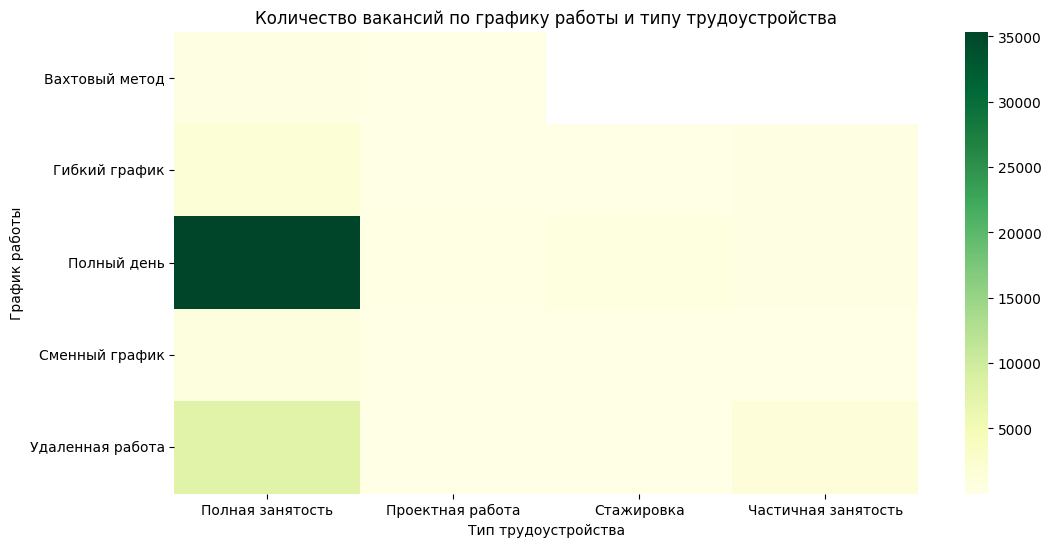

In [32]:
df = pd.read_sql_query(query_4_4, connection)

df = df.rename(columns={
    'schedule': 'График работы',
    'employment': 'Тип трудоустройства',
    'vacancies': 'Количество вакансий'
})

pivot = df.pivot_table(
    values='Количество вакансий',
    columns='Тип трудоустройства',
    index='График работы',
)
plt.figure(figsize=(12,6))

heatmap = sns.heatmap(data=pivot, cmap='YlGn')
heatmap.set_title('Количество вакансий по графику работы и типу трудоустройства');

5. Напишите запрос, выводящий значения поля «Требуемый опыт работы» (`experience`) в порядке возрастания количества вакансий, в которых указан данный вариант опыта.

In [33]:
# текст запроса
query_4_5 = f'''WITH exp_how_many AS ( -- это основная таблица
                    SELECT experience, COUNT(id) quantity FROM vacancies
                    GROUP BY experience -- группировка по опыту
                )
                SELECT experience, quantity,
                    ROUND(quantity/(SELECT SUM(quantity) FROM exp_how_many)*100, 1) percent
                FROM exp_how_many
                ORDER BY quantity
            '''

In [34]:
# результат запроса
df = pd.read_sql_query(query_4_5, connection)
df

,experience,quantity,percent
0,Более 6 лет,1337,2.7
1,Нет опыта,7197,14.6
2,От 3 до 6 лет,14511,29.5
3,От 1 года до 3 лет,26152,53.2


***

## **Выводы по детальному анализу данных**

В ходе детального анализа данных были получены следующие результаты:
1. В топ-5 по количеству вакансий входят крупнейшие по численности населения города России, Беларуси и Казахстана. Наибольшее количетсво вакансий представлено в Москве - 5 333 (10,84% от общего числа вакансий в базе данных - 49 197), далее идет Санкт-Петербург 2 851 (5,76% от общего числа вакансий), на 3 месте Минск 2 112 (4,29% от общего числа вакансий), на 4 месте Новосибирск 2 006 вакансий (4,08% от общего числа вакансий), на 5 месте Алматы - 1 892 (3,85% от общего числа вакансий). В базе присутствуют страны за пределами СНГ, такие как Индия, Германия, Китай, Польша, США и т.д. Это может указывать на международные вакансии или возможности трудоустройства в других странах.
2. В 24 073 вакансиях заполнено только одно из двух полей с зарплатой. Из этого количетсва только у 11 383 вакансий (47,29%) указана заработная плата ДО, это может отпугнуть потенциальных соискателей, так как нет возможности повысить свою заработную плату, а также нет возможности расчитать свою минимальную заработную плату. У 12 690 вакансий (52,71%) указан только заработная плата ОТ, это поможет потенциальным соискателям определить свой минимальный доход и рассчитывать на премии, бонусы, надбавки и т.д.
3. Разница между средней верхней и нижней границей составляет 39 472, то есть в среднем специалисты с высокими навыками и опытом работы получают на 39 472 больше, чем специалисты без опыта. Также следует отметить, что средние значения могли быть искажены вакансиями с экстремально высокими зарплатами. Для этого мы расчитали медианную границу заработной вилки. Разница между медианными значениями (30 000) показывает, что даже в типичных случаях работодатели готовы повышать зарплату на 60% в зависимости от навыков и опыта кандидата. Медианные значения ближе к зарплатам начального и среднего уровня, что говорит о преобладании таких вакансий в выборке. Высокие зарплаты (100 000+) встречаются реже и не являются массовыми.
4. 72% (35 367 вакансий) из всех вакансий работодатели ищут сотрудников на полную занятость и полный день, 16% - на полную занятость и удалённую работу, 3% - на полную занятость и гибкий график. Рынок труда остается консервативным, но тренд на гибкость и удаленную работу набирает обороты. Для работодателей важно адаптироваться к меняющимся ожиданиям сотрудников, особенно в высококонкурентных отраслях.
5. 53,2% вакансий относятся к кандидатам с опытом от 1 года до 3 лет, что составляет 26 152 вакансий. Это может свидетельствовать о том, что работодатели чаще всего ищут людей с некоторым, но не слишком большим опытом, что соответствует среднему уровню квалификации. Вакансии для кандидатов с опытом от 3 до 6 лет составляют 29,5% (14 511 вакансий). Это также значительная доля, что говорит о востребованности специалистов с уже приобретённым опытом и более высоким уровнем компетенции. 14,6% вакансий (7 197 вакансий) ориентированы на кандидатов без опыта. Это показатель, который может свидетельствовать о том, что работодатели готовы обучать новичков или предлагают стажировки, но таких вакансий всё же меньше, чем для опытных специалистов. Вакансий для людей с опытом более 6 лет всего 2,7% (1 337 вакансий), что говорит о меньшей потребности в высококвалифицированных специалистах, возможно, из-за того, что такие кандидаты часто занимают более высокие или узкоспециализированные должности.

## 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [35]:
# текст запроса
query_5_1 = f'''WITH ranked_employers AS (
                    SELECT e.name, COUNT(v.id) AS vacancy_count,
                    ROW_NUMBER() OVER (ORDER BY COUNT(v.id) DESC) AS rn
                FROM public.employers e
                JOIN public.vacancies v ON e.id = v.employer_id
                    GROUP BY e.name
                )
                SELECT name, vacancy_count
                FROM ranked_employers
                WHERE rn IN (1, 2, 3, 4, 5);
            '''

In [36]:
# результат запроса
df = pd.read_sql_query(query_5_1, connection)
df

,name,vacancy_count
0,Яндекс,1933
1,Ростелеком,491
2,Тинькофф,444
3,СБЕР,428
4,Газпром нефть,331


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [37]:
# текст запроса
query_5_2 = f'''SELECT
                    a.name,
                    vacan.vacan_quantity,
                    employ.employ_quantity
                FROM areas a -- основная таблица
                     LEFT JOIN (SELECT
                                    a.id id,
                                    COUNT(v.id) vacan_quantity
                                FROM
                                    vacancies v
                                    LEFT JOIN areas a ON v.area_id = a.id
                                GROUP BY a.id -- таблица вакансий с названиями регионов и количеством вакансий в них
                                ) vacan ON a.id = vacan.id
                     LEFT JOIN (SELECT
                                    a.id id,
                                    COUNT(e.id) employ_quantity
                                FROM
                                    employers e
                                    LEFT JOIN areas a ON e.area = a.id
                                GROUP BY a.id -- таблица employ с названиями регионов и количеством работодателей в них
                                ) employ ON a.id = employ.id
                WHERE employ_quantity IS NOT NULL -- оставим только те регионы, в которых есть хотя бы один работодатель
                ORDER BY vacan_quantity DESC, employ_quantity DESC -- сортируем по количеству вакансий по убыванию
             '''

In [38]:
# результат запроса
df = pd.read_sql_query(query_5_2, connection)
df

,name,vacan_quantity,employ_quantity
0,Россия,NaN,410
1,Казахстан,NaN,207
2,Московская область,NaN,75
3,Краснодарский край,NaN,19
4,Ростовская область,NaN,18
...,...,...,...
649,Электроугли,1.0,1
650,Белореченск,1.0,1
651,Красный Сулин,1.0,1
652,Заволжье,1.0,1


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [39]:
# текст запроса
query_5_3 = f'''SELECT
                    e.name,
                    COUNT(DISTINCT v.area_id) quantity -- количество регионов для каждого работодателя
                FROM
                    vacancies v
                    LEFT JOIN employers e ON v.employer_id = e.id
                GROUP BY e.id -- группируем по id работодателя
                ORDER BY quantity DESC
            '''

In [40]:
# результат запроса
df = pd.read_sql_query(query_5_3, connection)
df

,name,quantity
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71
...,...,...
14901,НПП Авиатрон,1
14902,Центр дистанционных торгов,1
14903,Городские Телекоммуникационные Системы,1
14904,"Введенский, Отель",1


Получим информацию ИП Поляков Денис Иванович, который занимает 4 место по количеству регионов:
* из какого региона этот работодатель,
* в каких сферах деятельности он предлагает вакансии,
* в каких регионах предлагаются вакансии,
* какие именно вакансии (название, график, оплата, регион вакансии и т.д.).

In [41]:
query_5_3_1 = f'''SELECT
                    e.id id_eployer,
                    e.name,
                    a.name area
                FROM
                    employers e
                    JOIN areas a ON e.area = a.id -- присоединяем только для имени региона
                WHERE
                    e.id = 5130287 -- мы знаем, что это id ИП Поляков Денис Иванович
             '''

In [42]:
df = pd.read_sql_query(query_5_3_1, connection)
df

,id_eployer,name,area
0,5130287,Поляков Денис Иванович,Владивосток


In [43]:
query_5_3_2 = f'''SELECT
                    a.name area_vacancy,
                    COUNT(*) quantity
                FROM
                    vacancies v
                    LEFT JOIN areas a ON v.area_id = a.id -- добавляем названия регионов
                WHERE
                    v.employer_id = 5130287
                GROUP BY a.name -- сгруппируем по названию региона
                ORDER BY quantity DESC, area_vacancy -- отсортируем по количеству вакансий по убыванию
             '''

In [44]:
df = pd.read_sql_query(query_5_3_2, connection)
df

,area_vacancy,quantity
0,Орск,3
1,Балаково,2
2,Бийск,2
3,Братск,2
4,Брянск,2
...,...,...
83,Усолье-Сибирское,1
84,Уссурийск,1
85,Чита,1
86,Южно-Сахалинск,1


In [45]:
query_5_3_3 = f'''SELECT
                    v.name,
                    v.schedule,
                    v.experience,
                    v.employment,
                    v.salary_from,
                    v.salary_to,
                    a.name area_vacancy
                FROM
                    vacancies v
                    LEFT JOIN areas a ON v.area_id = a.id
                WHERE
                    v.employer_id = 5130287
                ORDER BY  v.salary_from DESC, v.salary_to DESC
             '''

In [46]:
df = pd.read_sql_query(query_5_3_3, connection)
df

,name,schedule,experience,employment,salary_from,salary_to,area_vacancy
0,Компьютерный мастер,Полный день,От 1 года до 3 лет,Полная занятость,70000,NaN,Тула
1,Компьютерный мастер,Полный день,От 1 года до 3 лет,Полная занятость,60000,NaN,Кемерово
2,Компьютерный мастер,Полный день,От 1 года до 3 лет,Полная занятость,60000,NaN,Курск
3,Компьютерный мастер,Полный день,От 1 года до 3 лет,Полная занятость,60000,NaN,Оренбург
4,Компьютерный мастер,Полный день,От 1 года до 3 лет,Полная занятость,60000,NaN,Набережные Челны
...,...,...,...,...,...,...,...
122,Ученик компьютерного мастера,Полный день,Нет опыта,Стажировка,30000,50000.0,Геленджик
123,Ученик компьютерного мастера,Полный день,Нет опыта,Стажировка,30000,50000.0,Балаково
124,Ученик компьютерного мастера,Полный день,Нет опыта,Стажировка,30000,50000.0,Новороссийск
125,Ученик компьютерного мастера,Полный день,Нет опыта,Стажировка,30000,50000.0,Тюмень


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности.

In [47]:
# текст запроса
query_5_4 = f'''SELECT
                    COUNT(*)
                FROM
                    employers e
                    FULL JOIN employers_industries e_i ON e.id = e_i.employer_id
                WHERE
                    e_i.industry_id IS NULL -- оставляем только записи с пустыми полями id сферы деятельности и считаем их количество
            '''

In [48]:
# результат запроса
df = pd.read_sql_query(query_5_4, connection)
df

,count
0,8419


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности.

In [49]:
# текст запроса
query_5_5 = f'''SELECT
                    e.name
                FROM
                    employers_industries e_i
                    LEFT JOIN employers e ON e_i.employer_id = e.id
                GROUP BY e.id -- группируем по id работодателя
                HAVING COUNT(e_i.industry_id) = 4 -- оставляем только тех работодателей, у которых 4 сферы деятельности
                ORDER BY name -- сортировка по алфавиту
                OFFSET 2
                LIMIT 1
            '''

In [50]:
# результат запроса
df = pd.read_sql_query(query_5_5, connection)
df

,name
0,2ГИС


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана «Разработка программного обеспечения».


In [51]:
# текст запроса
query_5_6 = f'''SELECT
                    COUNT(DISTINCT employer_id) quantity -- подсчет количества уникальных id работодателей
                FROM
                    employers_industries e_i
                    LEFT JOIN industries i ON e_i.industry_id = i.id -- добавляем названия сфер деятельности
                WHERE i.name ~ 'Разработка программного обеспечения' -- только те работодатели, у кого указано требуемое название
             '''

In [52]:
# результат запроса
df = pd.read_sql_query(query_5_6, connection)
df

,quantity
0,3553


7. Для компании «Яндекс» выведите список [городов-миллионников](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8), в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку "Total" с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

    Если возникнут трудности с этим заданием, посмотрите материалы модуля 6.4 «Как получать данные из веб-источников и API».

In [53]:
# код для получения списка городов-милионников
# URL страницы Википедии с информацией о городах-миллионерах России
url = 'https://ru.wikipedia.org/wiki/Города-миллионеры_России'

# Получаем страницу и проверяем, что запрос успешен
response = requests.get(url)
response.raise_for_status()

# Создаем объект BeautifulSoup
soup = BeautifulSoup(response.text, 'lxml')

# Находим таблицу с городами-миллионерами (обычно таблица имеет класс "standard sortable")
table = soup.find('table', class_='standard sortable')
if not table:
    raise ValueError("Не найдена таблица с городами-миллионерами.")

# Извлекаем все ссылки с атрибутами href и title из таблицы
links = table.select('a[href][title]')

# С помощью list comprehension формируем кортеж, фильтруя элементы:
# выбираем те, у которых название состоит не более чем из двух слов и начинается с заглавной буквы
city_list = tuple(link.text for link in links if len(link.text.split()) <= 2 and link.text[0].isupper())

print(city_list)

('Москва', 'Санкт-Петербург', 'Новосибирск', 'Екатеринбург', 'Казань', 'Красноярск', 'Нижний Новгород', 'Челябинск', 'Уфа', 'Самара', 'Ростов-на-Дону', 'Краснодар', 'Омск', 'Воронеж', 'Пермь', 'Волгоград')


In [54]:
# текст запроса
query_5_7 = f'''WITH tab AS (
                SELECT
                    a.name,
                    COUNT(*)::int cnt
                FROM
                    vacancies v
                    LEFT JOIN employers e ON v.employer_id = e.id
                    LEFT JOIN areas a ON v.area_id = a.id -- в таблицу вакансий добавляем названия работодателей и регионов
                WHERE
                    e.name LIKE 'Яндекс' -- условие: только Яндекс
                    AND a.name IN {city_list} -- условие: только из кортежа миллионников
                GROUP BY a.id
                ) -- cоздаем таблицу с регионами из заданного списка (города-миллионники) и количеством вакансий для каждого, исключительно для Яндекса
                SELECT
                    *
                FROM tab
                UNION -- добавляем к имеющейся таблице общее количество вакансий по всем городам-миллионникам
                SELECT
                    'Total',
                    SUM(cnt) -- общая сумма вакансий
                FROM tab
                ORDER BY cnt -- сортируем по количеству вакансий по возрастанию
             '''

In [55]:
# результат запроса
df = pd.read_sql_query(query_5_7, connection)
df

,name,cnt
0,Омск,21
1,Челябинск,22
2,Красноярск,23
3,Волгоград,24
4,Пермь,25
5,Казань,25
6,Ростов-на-Дону,25
7,Уфа,26
8,Самара,26
9,Краснодар,30


***

## **Выводы по анализу работодателей**

В ходе анализа работодателей были получены следующие результаты:
1. В топ-5 работодателей по количеству вакансий входят: "Яндекс" - 1 933 вакансий (4% от всех вакансий), "Ростелеком" - 491 (1%), "Тинькофф" - 444 (0.9%), "Сбер" - 428 (0.9%), "Газпром нефть" - 331 (0.7%).
2. В регионе "Россия" самое большое количество работодателей при отсутствии размещённых в данном регионе вакансий. Возможно это связано с тем, что на HH не совсем корректно указывается регион (страна), а также области, в которых есть работодатели, но отсутствуют вакансии.
3. Яндекс и Ростелеком лидируют по количеству регионов (181 и 152 соответственно), что отражает их статус крупных федеральных компаний с развитой инфраструктурой. Спецремонт (116 регионов) и ООО ЕФИН (71 регион) демонстрируют значительное присутствие в регионах, вероятно, за счет сетевой бизнес-модели (например, ремонтные услуги, финансовые продукты). ИП Поляков Денис Иванович (88 регионов) — необычно высокая активность для ИП. ИП Поляков Денис Иванович зарегистрировано во Владивостоке. Вакансии Полякова Д.И. размещены для 88 регионов (почти в каждом регионе России). Всего этот ИП разместил 127 вакансий.
Вакансии - компьютерный мастер либо ученик компьютерного матера. Возможно это франшиза или партнерская сеть.
4. В 17% (8 419 вакансий) из всех вакансий работодатели не указывают сферу деятельности.
5. 15% (3 553 работодателя) из всех работодатеелй указывают в сферах деятельности вакансии "Разработка программного обеспечения". Это говорит о том, что существует потребность у компаний в разработчиках ПО.
6. 25% (485 вакансий) от общего числа вакансий "Яндекс" представлены во всех российских городах-миллионниках.

## 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

    Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова `'data'` или `'данн'`.

    *Обратите внимание, что названия вакансий могут быть написаны в любом регистре.*


In [56]:
# текст запроса
query_6_1 = f'''SELECT COUNT(*)
                FROM vacancies v
                WHERE
                    lower(v.name) ~* 'data' OR lower(v.name) ~* 'данн' -- приводим значение поля к нижнему регистру и проверяем наличие двух заданных эелементов в нем
             '''

In [57]:
# результат запроса
df = pd.read_sql_query(query_6_1, connection)
df

,count
0,1771


2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
    * 'data scientist'
    * 'data science'
    * 'исследователь данных'
    * 'ML' (здесь не нужно брать вакансии по HTML)
    * 'machine learning'
    * 'машинн%обучен%'

    **В следующих заданиях мы продолжим работать с вакансиями по этому условию.**

    Считаем вакансиями для специалистов уровня Junior следующие:
    + в названии есть слово “junior” **или**
    + требуемый опыт — «Нет опыта» **или**
    + тип трудоустройства — «Стажировка».


In [58]:
# текст запроса
query_6_2 = f'''SELECT COUNT(*)
                FROM vacancies
                WHERE (
                    name ~* 'data scientist' OR
                    name ~* 'data science' OR
                    name ~* 'исследователь данных' OR
                    (name ~* 'ML' AND name !~* 'HTML') OR
                    name ~* 'machine learning' OR
                    name ~* 'машинн.*обучен.*'
                ) -- применение условия для соответствия вакансии DS
                AND (
                    lower(name) ~* 'junior' OR
                    experience ='Нет опыта' OR
                    employment = 'Стажировка'
                ) -- применение условия для уровня junior: наличие элемента junior в поле name, для опыта и занятости соответствие заданным значениям
             '''

In [59]:
# результат запроса
df = pd.read_sql_query(query_6_2, connection)
df

,count
0,51


Узнаем, сколько вакансий являются стажировками

In [60]:
query_6_2_1 = f'''SELECT COUNT(*)
                  FROM vacancies
                  WHERE (
                      name ~* 'data scientist' OR
                      name ~* 'data science' OR
                      name ~* 'исследователь данных' OR
                      (name ~* 'ML' AND name !~* 'HTML') OR
                      name ~* 'machine learning' OR
                      name ~* 'машинн.*обучен.*'
                  ) -- применение условия для соответствия вакансии DS
                  AND (
                      lower(name) ~* 'junior' OR
                      experience = 'Нет опыта' OR
                      employment = 'Стажировка'
                  ) -- применение условия для уровня junior: наличие элемента junior в поле name, для опыта и занятости соответствие заданным значениям
                  AND employment = 'Стажировка'; -- добавлено условие для вакансий с типом "Стажировка"
               '''

In [61]:
# результат запроса
df = pd.read_sql_query(query_6_2_1, connection)
df

,count
0,4


Определим топ-20 регионов для начинающих специалистов DS по средней заработной плате

In [62]:
query_6_2_2 = f'''SELECT a.name area,
                      round(avg(coalesce((v.salary_from+v.salary_to)/2, v.salary_from, v.salary_to, 0))) avg_salary,
                      count(v.id) count
                  FROM vacancies v
                  JOIN areas a ON v.area_id=a.id
                  WHERE v.name ilike '%data%'
                    OR v.name ilike '%данн%'
                    AND (v.salary_from IS NOT NULL
                      OR v.salary_to IS NOT NULL)
                    AND (v.name ilike '%junior%'
                      OR v.experience='Нет опыта'
                      OR v.employment='Стажировка')
                  GROUP BY 1
                  ORDER BY 2 DESC
                  LIMIT 20
               '''

In [63]:
# результат запроса
df = pd.read_sql_query(query_6_2_2, connection)
df

,area,avg_salary,count
0,Сербия,150000.0,6
1,Ростов (Ярославская область),140000.0,1
2,Королев,130000.0,1
3,Рязань,126250.0,2
4,Кипр,124766.0,9
5,Турция,120000.0,5
6,Ульяновск,108333.0,3
7,Испания,100000.0,3
8,Коломна,97500.0,1
9,Луховицы,97500.0,1


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или Postgres?

    *Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [64]:
# текст запроса
query_6_3 = f'''SELECT COUNT(*)
                FROM vacancies
                WHERE (
                    name ~* 'data scientist' OR
                    name ~* 'data science' OR
                    name ~* 'исследователь данных' OR
                    (name ~* 'ML' AND name !~* 'HTML')  OR
                    name ~* 'machine learning' OR
                    name ~* 'машинн.*обучен.*'
                ) -- применение условия для соответствия вакансии DS
                AND (
                    key_skills ~* 'SQL' OR
                    key_skills ~* 'postgres'
                ) -- соответствие условию наличия двух ключевых навыков, причем в любом месте значения поля (с учетом регистра)
             '''

In [65]:
# результат запроса
df = pd.read_sql_query(query_6_3, connection)
df

,count
0,229


4. Проверьте, насколько популярен Python в требованиях работодателей к DS. Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

    *Это можно сделать помощью запроса, аналогичного предыдущему.*

In [66]:
# текст запроса
query_6_4 = f'''SELECT COUNT(*)
                FROM vacancies
                WHERE (
                    name ~* 'data scientist' OR
                    name ~* 'data science' OR
                    name ~* 'исследователь данных' OR
                    (name ~* 'ML' AND name !~* 'HTML')  OR
                    name ~* 'machine learning' OR
                    name ~* 'машинн.*обучен.*'
                ) -- применение условия для соответствия вакансии DS
                AND
                    key_skills ~* 'Python' -- соответствие условию наличия двух ключевых навыков, причем в любом месте значения поля (с учетом регистра)
             '''

In [67]:
# результат запроса
df = pd.read_sql_query(query_6_4, connection)
df

,count
0,357


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до **двух знаков после точки-разделителя**.

In [68]:
# текст запроса
query_6_5 = f'''SELECT
                    ROUND(AVG(length(key_skills) - length(replace(key_skills, '\t', '')) + 1), 2) skills
                FROM vacancies
                WHERE (
                    name ~* 'data scientist' OR
                    name ~* 'data science' OR
                    name ~* 'исследователь данных' OR
                    (name ~ 'ML' AND name !~* 'HTML')  OR
                    name ~* 'machine learning' OR
                    name ~* 'машинн.*обучен.*'
                ) -- применение условия для соответствия вакансии DS
                AND key_skills IS NOT NULL -- исключаем пустые значения
            '''

In [69]:
# результат запроса
df = pd.read_sql_query(query_6_5, connection)
df

,skills
0,6.41


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в среднем указывают для каждого типа требуемого опыта (уникальное значение из поля `experience`).

    При решении задачи примите во внимание следующее:
    1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
    2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
    3. Если в расчётах участвует `null`, в результате он тоже даст `null` (посмотрите, что возвращает запрос `select 1 + null`). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит `null` на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

    Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до **целого числа**.

In [70]:
# текст запроса
query_6_6 = f'''SELECT
                    experience,
                    ROUND(AVG((COALESCE(salary_from, salary_to) + COALESCE(salary_to, salary_from)) / 2))::int avg_salary -- рассчитываем среднюю зарплату по группам и округляем до целого числа
                FROM vacancies
                WHERE (
                    name ~* 'data scientist' OR
                    name ~* 'data science' OR
                    name ~* 'исследователь данных' OR
                    (name ~ 'ML' AND name !~* 'HTML')  OR
                    name ~* 'machine learning' OR
                    name ~* 'машинн.*обучен.*'
                ) -- применение условия для соответствия вакансии DS
                AND (salary_from IS NOT NULL OR salary_to IS NOT NULL) -- выбираем вакансии, у которых заполнено хотя бы одно поле зарплаты
                GROUP BY experience  -- группируем результаты по значению требуемого опыта
                ORDER BY avg_salary DESC -- сортируем группы по средней зарплате в порядке убывания
             '''

In [71]:
# результат запроса
df = pd.read_sql_query(query_6_6, connection)
df

,experience,avg_salary
0,От 3 до 6 лет,243115
1,От 1 года до 3 лет,139675
2,Нет опыта,74643


***

## **Выводы по предметному анализу**

В ходе предметного анализа были получены следующие результаты:
1. Наличие 1771 вакансии (3,6% от общего числа вакансий) указывает на активный спрос в сфере анализа данных, машинного обучения, BI и смежных направлениях. Это подтверждает тренд на цифровизацию бизнеса и рост важности data-driven решений.
2. Всего 51 вакансия соответствует критериям Junior в сфере Data Science. Это указывает на: высокую конкуренцию среди начинающих специалистов; строгие требования даже для entry-level позиций (например, наличие портфолио, базовых навыков или профильного образования). Компании чаще нанимают специалистов с опытом, что усложняет вход в профессию для новичков. Из 51 вакансии всего 4 являются стажировками.
 - Начинающие DS могут рассчитывать на высокие зарплаты в международных локациях (Сербия, Кипр, Турция) и некоторых российских городах (Рязань, Ульяновск), однако большинство предложений в крупных городах (Екатеринбург, Воронеж) предлагают средние зарплаты (~50–70 тыс. руб.), а единичные высокооплачиваемые вакансии в малых регионах носят нетипичный характер.
3. Знание SQL или Postgres требуется в 229 вакансиях для Data Science, что подчеркивает их критическую важность для работы с данными, включая задачи анализа, обработки и управления базами данных, и подтверждает необходимость освоения этих навыков для успешного трудоустройства в данной сфере.
4. Python указан как ключевой навык в 357 вакансиях для Data Science, что подтверждает его статус основного языка для задач анализа данных, машинного обучения и автоматизации, делая его обязательным для освоения дата-сайентистами.
5. В среднем в вакансиях для Data Science указывают 6.41 ключевых навыка, что отражает высокие требования к разносторонней подготовке кандидатов и необходимость владения широким спектром инструментов и технологий.
6. Зарплата Data Scientist напрямую зависит от опыта: специалисты с опытом 3–6 лет получают в среднем 243 115₽, с 1–3 годами — 139 675, а новички без опыта — 74 643, что подтверждает рост дохода с увеличением экспертизы и стажа.

## **Общий вывод по проекту**



Проведённый анализ данных о вакансиях выявил ключевые тенденции рынка труда, особенности спроса на специалистов и требования работодателей. Основные результаты:

1. **Общая картина рынка:**
 - В базе представлено 49 197 вакансий от 23 501 работодателя, что демонстрирует активность компаний в поиске сотрудников.
 - IT-сектор доминирует: Яндекс, Ростелеком, Тинькофф и СБЕР лидируют по количеству вакансий.
 - География: 56% регионов имеют активные вакансии, но 44% остаются без вакансий, что указывает на неравномерное распределение возможностей.

2. **Зарплаты:**
 - Средняя вилка: 71 065 – 110 537 руб., медианная: 50 000 – 80 000 руб. Разрыв подтверждает влияние выбросов (высокие зарплаты senior-специалистов).
 - Data Science: Опыт напрямую влияет на доход. Средние зарплаты:

3–6 лет: 243 115 руб.

1–3 года: 139 675 руб.

Нет опыта: 74 643 руб.

3. **Требования к специалистам:**

Data Science:
- Python упоминается в 357 вакансиях, SQL/Postgres — в 229.
- В среднем требуется 6.41 навык на вакансию, что подчёркивает многопрофильность профессии.
- Junior-специалисты: Всего 51 вакансия, включая 4 стажировки. Высокая конкуренция требует усиленной подготовки.

4. **Работодатели:**
  - Топ-5: Яндекс (1 933 вакансии), Ростелеком (491), Тинькофф (444), СБЕР (428), Газпром нефть (331).
  - ИП Поляков Денис Иванович — уникальный кейс: 127 вакансий в 88 регионах (компьютерные мастера), что предполагает сетевую бизнес-модель.
  - 17% работодателей не указывают сферу деятельности, что снижает прозрачность данных.

5. **Форматы работы:**
  - 72% вакансий — полный день + полная занятость.
  - Удалённая работа занимает 16%


**Рынок труда сохраняет консервативные черты, но адаптируется к цифровым трендам. Data Science остаётся перспективным направлением, однако вход в профессию требует серьёзной подготовки.**

## **Возможные дальнейшие исследования:**

1. Динамика рынка труда:
 - Изучить, как меняется количество вакансий и уровень зарплат по кварталам/годам.
 - Выявить сезонные тренды (например, рост вакансий в IT к концу года).

2. Географический анализ:
 - Определить, в каких городах наблюдается дефицит специалистов (высокий спрос при низком количестве кандидатов).

3. Анализ навыков:
 - Выявить топ-10 востребованных навыков для Data Science и их связь с зарплатой.
 - Исследовать, как комбинации навыков (например, Python + SQL + TensorFlow) влияют на доход.

4. Влияние компании:
 - Сравнить условия труда в стартапах, корпорациях и государственных организациях.
 - Проанализировать, как размер компании коррелирует с уровнем зарплат и требованиями к опыту.

5. Сравнение с международным рынком:
 - Сопоставить зарплаты и требования к Data Scientist в России, США и Европе.
 - Изучить, какие навыки чаще требуются за рубежом.

6. Эффективность стажировок:
 - Определить, какой процент стажеров получает постоянное трудоустройство.
 - Проанализировать, какие компании чаще нанимают junior-специалистов после стажировки.

7. Гендерный аспект:
 - Исследовать, существует ли разрыв в зарплатах между мужчинами и женщинами в IT-сфере.
 - Выявить отрасли с наибольшим гендерным дисбалансом.

8. Влияние образования:
 - Проанализировать, как наличие высшего образования или сертификатов влияет на зарплату.
 - Сравнить требования к образованию в разных отраслях (финансы, медицина, ритейл).

**Эти исследования помогут глубже понять структуру рынка, выявить скрытые закономерности и предложить данные для принятия решений как соискателям, так и работодателям.**

In [72]:
connection.close()